# Exploratory Data Analysis

***

## Overview:

In this notebook we perform an exploratory data analysis over ERA5 dataset with a special focus on wind data in Barajas Airport (40.5, -3.5)


## Procedure:

Wind speeds can be calculated using MERRA-2 eastward and northward wind components. Before we calculate wind speed we will define the wind components, also referred to as vectors.

Eastward and northward wind vectors are represented by the variables “u” and “v” respectively. MERRA-2 u wind is parallel to the x-axis (i.e. longitude). A positive u wind comes from the west, and a negative u wind comes from the east. MERRA-2 v wind is parallel to the y-axis (i.e. latitude). A positive v wind comes from the south, and a negative v wind comes from the north. These variable long names typically contain "eastward wind" or "northward wind" at a given pressure or height. Example long name: 2-meter eastward wind.

Given the u and v wind components, we can calculate the wind speed using the Pythagorean Theorem:

_Wind Speed_ = $ \sqrt{u^2+v^2} $

<img src ="https://disc.gsfc.nasa.gov/api/images/windspeed_diagram/file" title="Image3" width="500"/>

To find the direction of wind speed, use arctan(v/u) when u is not equal to zero. You also must adjust for what quadrant you are in based on the sign of u and v. Most scripting languages (Python, matlab, IDL, etc.) have an arctan2 function that will take care of these issues for you. Be careful to note whether you are working in radians or degrees when determining your direction.

**NOTE:** It is important to use the arctan2 (two-argument arctangent) function rather than the arctan (inverse tangent) function.  The arctan2 function returns the angle for the component vectors u and v on a Cartesian plane.  The arctan function returns the angle for the ratio of the component vectors (i.e. v/u) on a Cartesian plane and will have non-unique values depending upon which quadrant in which the resultant vector lies.

Most scripting languages also have packages that can compute the wind magnitudes for you. We use the "quiver" plot function that is part of the matplotlib library. The code below is a Python script that will compute and plot wind speed and direction from MERRA-2 wind vector components. We also compute the daily averaged wind speed as the variable "<font color=red>ws_daily_avg</font>".

 

**NOTE**: To compute, daily, weekly, and especially monthly averaged wind speed values, the user should use hourly north and east wind component variables to compute the hourly wind speed averages. Then use those hourly wind speed averages to compute the average daily, weekly or monthly wind speed.

### PLOT MERRA-2 WIND SPEED 
The first step is to import the required Python libraries. The netCDF4 Dataset and numpy imports allow you to read in the file and perform calculations. The matplotlib and cartopy libraries allow you to plot the data. If any of the following import commands fail, check the local Python environment and install any missing packages.

In [86]:
#!pip install cartopy
#!sudo apt install ffmpeg
#!pip install pandas
#!pip install plotly

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 10.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [76]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import warnings
import datetime
import pandas as pd
import plotly.express as px
warnings.filterwarnings("ignore")

%matplotlib inline

Open the NetCDF4 file (add a directory path if necessary) for reading:

In [7]:
data = Dataset('/home/windgust/workspace/project/data/raw/2018-10-surface.nc', mode='r')

Run the following cell to see the MERRA-2 metadata. This line will print attribute and variable information. From the 'variables(dimensions)' list, choose which variable(s) to read in below:

In [8]:
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-11-30 22:44:01 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data8/adaptor.mars.internal-1701384224.7458875-4949-13-74a30e93-c3d1-4a26-90e0-a63d335a20c5.nc /cache/tmp/74a30e93-c3d1-4a26-90e0-a63d335a20c5-adaptor.mars.internal-1701383962.979885-4949-27-tmp.grib
    dimensions(sizes): longitude(57), latitude(41), time(744)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 u100(time, latitude, longitude), int16 v100(time, latitude, longitude), int16 u10(time, latitude, longitude), int16 v10(time, latitude, longitude), int16 d2m(time, latitude, longitude), int16 t2m(time, latitude, longitude), int16 z(time, latitude, longitude), int16 msl(time, latitude, longitude), int16 lsm(time, latitude, longitude)
    groups: 


Read in variables:

In [9]:
# longitude and latitude
lons = data.variables['longitude']
lats = data.variables['latitude']
lon, lat = np.meshgrid(lons, lats)
# 2-meter eastward wind m/s
U2M = data.variables['u10']
# 2-meter northward wind m/s
V2M = data.variables['v10']

Replace \_FillValues with NaNs:

In [10]:
U2M_nans = U2M[:]
V2M_nans = V2M[:]
_FillValueU2M = U2M._FillValue
_FillValueV2M = V2M._FillValue
U2M_nans[U2M_nans == _FillValueU2M] = np.nan
V2M_nans[V2M_nans == _FillValueV2M] = np.nan

Calculate wind speed:

In [11]:
ws = np.sqrt(U2M_nans**2+V2M_nans**2)

Calculate wind direction in radians:

In [12]:
ws_direction = np.arctan2(V2M_nans,U2M_nans)

**NOTE:** The MERRA-2 file contains hourly data for 24 hours (t=24). To get the daily mean values, take the average along the time dimension. Calculate daily average wind speed and daily average wind direction (in radians):

In [13]:
ws_daily_avg = np.nanmean(ws, axis=0)

**NOTE:** To calculate the daily average wind direction correctly, it is important to use the 'vector average' as atan2(&lt;v&gt;,&lt;u&gt;), where &lt;v&gt; and &lt;u&gt; are the daily averages of the component vectors. Do not average the individual wind direction angles. This avoids a situation where averaging wind direction values 1 and 359 would give 180 instead of the desired 0. 

In [14]:
U2M_daily_avg = np.nanmean(U2M_nans, axis=0)
V2M_daily_avg = np.nanmean(V2M_nans, axis=0)
ws_daily_avg_direction = np.arctan2(V2M_daily_avg, U2M_daily_avg)

#### Plot wind speed with direction 
The filled contours show the wind speed. The "quiver" function is used to overlay arrows to show the wind direction. The length of the arrows is determined by the wind speed. 

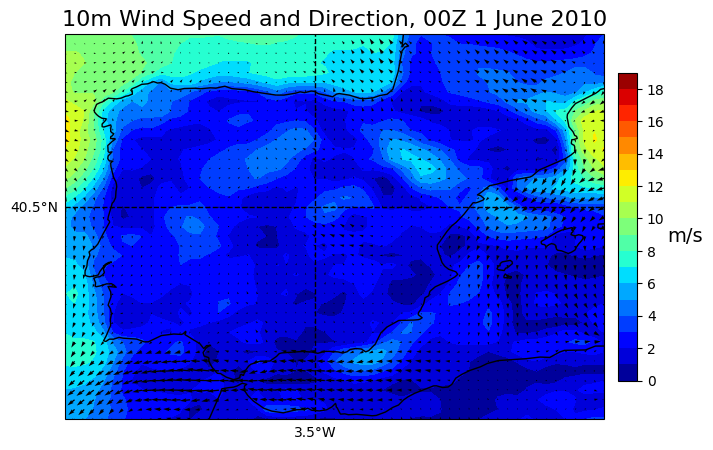

In [15]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10,4,35,45])  
ax.coastlines(resolution="50m",linewidth=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-3.5])
gl.ylocator = mticker.FixedLocator([40.5])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':10, 'color':'black'}
gl.ylabel_style = {'size':10, 'color':'black'}

# Plot windspeed
clevs = np.arange(0,20,1)
plt.contourf(lon, lat, ws[0,:,:], clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('10m Wind Speed and Direction, 00Z 1 June 2010', size=16)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('m/s',size=14,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)
# Overlay wind vectors
qv = plt.quiver(lon, lat, U2M_nans[100,:,:], V2M_nans[100,:,:], scale=420, color='k')

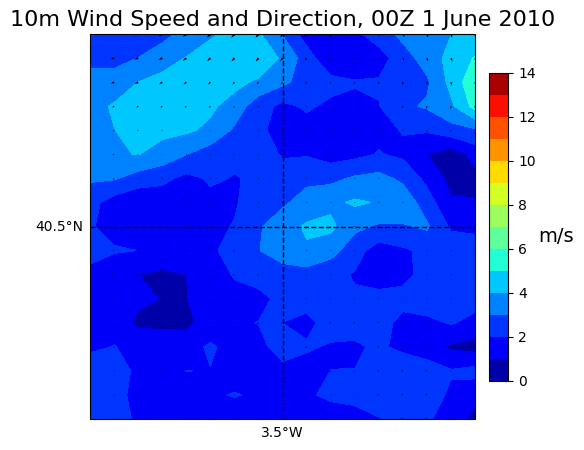

In [16]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-5.5,-1.5,38.5,42.5])  
ax.coastlines(resolution="10m",linewidth=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-3.5])
gl.ylocator = mticker.FixedLocator([40.5])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':10, 'color':'black'}
gl.ylabel_style = {'size':10, 'color':'black'}

# Plot windspeed
clevs = np.arange(0,15,1)
plt.contourf(lon, lat, ws[0,:,:], clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('10m Wind Speed and Direction, 00Z 1 June 2010', size=16)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('m/s',size=14,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)
# Overlay wind vectors
qv = plt.quiver(lon, lat, U2M_nans[540,:,:], V2M_nans[540,:,:], scale=420, color='k')

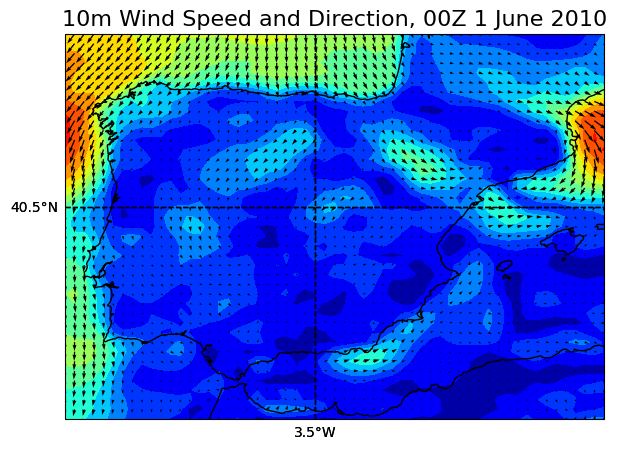

In [28]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Suponiendo que 'lon', 'lat', 'ws', 'U2M_nans', y 'V2M_nans' son tus datos de viento

# Función para actualizar cada cuadro de la animación
def update(frame):
    ax.clear()
    ax.set_extent([-10,4,35,45], crs=ccrs.PlateCarree())
    ax.coastlines(resolution="10m", linewidth=1)

    # Configuración de las líneas de la cuadrícula
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-3.5])
    gl.ylocator = mticker.FixedLocator([40.5])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    # Actualizar el gráfico de velocidad del viento
    clevs = np.arange(0, 15, 1)
    contour = plt.contourf(lon, lat, ws[frame,:,:], clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.jet)
    plt.title('10m Wind Speed and Direction, 00Z 1 June 2010', size=16)

    # Agregar vectores de viento
    plt.quiver(lon, lat, U2M_nans[frame,:,:], V2M_nans[frame,:,:], scale=420, color='k')

    return contour,

# Configurar la figura y los ejes
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Crear y correr la animación
ani = animation.FuncAnimation(fig, update, frames=range(0, len(ws)), blit=True)

plt.show()

## Wind rose

In [79]:
latitude = np.load('/home/windgust/workspace/project/data/constants/latitude.npy')
longitude = np.load('/home/windgust/workspace/project/data/constants/longitude.npy')
level = np.load('/home/windgust/workspace/project/data/constants/level.npy')
time = np.load('/home/windgust/workspace/project/data/processed/time.npy')
surface_data = np.load('/home/windgust/workspace/project/data/processed/surface.npy')
upper_data = np.load('/home/windgust/workspace/project/data/processed/upper.npy')
upper_var_names = ['u', 'v', 'q', 't', 'd', 'z', 'w', 'vo']
surface_var_names = ['u100', 'v100', 'u10', 'v10', 'd2m', 't2m', 'z', 'msl']

In [80]:
barajas_latitude = np.where(latitude == 40.5)[0][0]
barajas_longitude = np.where(longitude == -3.5)[0][0]

In [81]:
barajas_data = pd.DataFrame(surface_data[:,barajas_latitude,barajas_longitude,:], columns=surface_var_names, index=time)

In [104]:
# Convert the time format to datetime
base_time = datetime.datetime(1900, 1, 1)
barajas_data['date'] = base_time + pd.to_timedelta(barajas_data.index, unit='h')

# Calculate wind direction and speed
barajas_data['wind_dir_10'] = np.arctan2(barajas_data['v10'], barajas_data['u10'])
barajas_data['wind_speed_10'] = np.sqrt(barajas_data['u10']**2 + barajas_data['v10']**2)

barajas_data['wind_dir_100'] = np.arctan2(barajas_data['v100'], barajas_data['u100'])
barajas_data['wind_speed_100'] = np.sqrt(barajas_data['u100']**2 + barajas_data['v100']**2)

# Discretizar la variable de dirección del viento en rangos más pequeños
direction_bins = [-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
direction_labels = ['SW', 'S', 'SE', 'E', 'NE', 'N', 'NW', 'W']
barajas_data['wind_dir_10_category'] = pd.cut(barajas_data['wind_dir_10'], bins=direction_bins, labels=direction_labels)

# Discretizar la variable de velocidad del viento en rangos más pequeños
speed_bins = [0, 2, 5, 8, 10, 12, 15, np.inf]
speed_labels = ['0-2', '2-5', '5-8', '8-10', '10-12', '12-15', '15+']
barajas_data['wind_speed_10_category'] = pd.cut(barajas_data['wind_speed_10'], bins=speed_bins, labels=speed_labels)

barajas_data['wind_dir_100_category'] = pd.cut(barajas_data['wind_dir_100'], bins=direction_bins, labels=direction_labels)
barajas_data['wind_speed_100_category'] = pd.cut(barajas_data['wind_speed_100'], bins=speed_bins, labels=speed_labels)


In [105]:

# Calculate the frequency of each combination
frequency10 = barajas_data.groupby(['wind_speed_10_category', 'wind_dir_10_category']).size().reset_index(name='frequency')

frequency100 = barajas_data.groupby(['wind_speed_100_category', 'wind_dir_100_category']).size().reset_index(name='frequency')


In [107]:
import plotly.express as px
fig = px.bar_polar(frequency100, r="frequency", theta="wind_dir_100_category",
                   color="wind_speed_100_category", template="plotly_dark",
                   color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.show()

<Axes: >

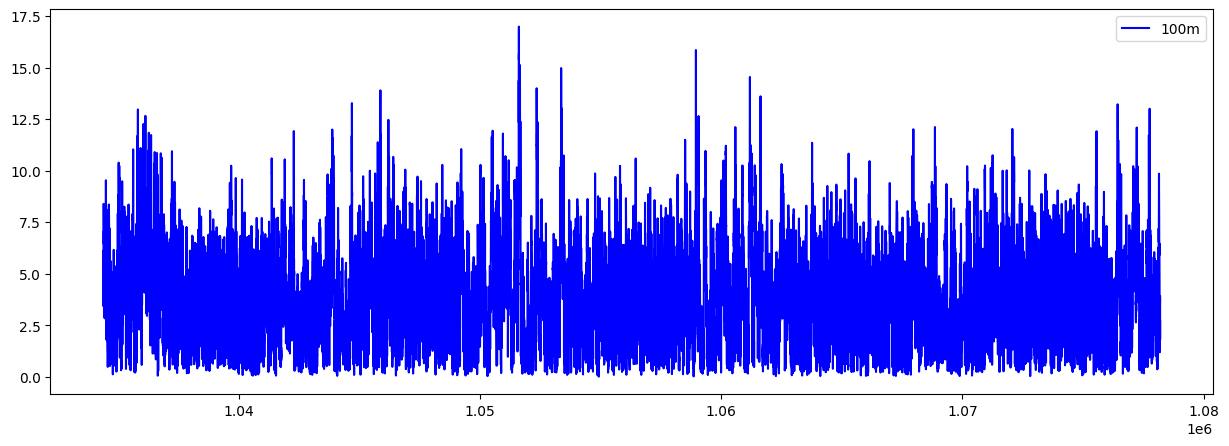

In [117]:
barajas_data['wind_speed_100'].plot(figsize=(15,5), color='blue', label='100m', legend=True)

In [118]:
print(barajas_data['wind_speed_10'].max())
print(barajas_data['wind_speed_100'].max())

10.472732
16.984152


In [122]:
print(max(barajas_data['u100']))

13.55937385559082
